In [1]:
## Tratamiento de datos
# ==============================================================================

import pandas as pd
import numpy as np

## Graficos
# ==============================================================================

import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================

# from sklearn.compose import ColumnTransformer #Para tranformar columnas en onehotencoding
# from sklearn.preprocessing import OneHotEncoder  #Para tranformar columnas en onehotencoding
#from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier #Para usar randomForest
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score #Con esto tuneamos los hiperparametros en la valid. cruzada
from sklearn.model_selection import ParameterGrid #Con esto tuneamos con los grids
import multiprocessing #para usar varios procesadores
from sklearn.model_selection import RepeatedKFold #para validacion cruzada
# from sklearn import tree

# Evaluacion
# ==============================================================================

from utils import evaluate

# Lectura bases de datos

In [6]:
X_train = pd.read_parquet('../data/X_train.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')

X_test  = pd.read_parquet('../data/X_test.parquet')
y_test  = pd.read_parquet('../data/y_test.parquet')

In [7]:
features_selected = ['serum_sodium', 
                     'platelets', 
                     'creatinine_phosphokinase', 
                     'age',
                     'ejection_fraction',
                     'serum_creatinine'
                    ]

X_train = X_train.loc[: , features_selected]
X_test = X_test.loc[: , features_selected]

In [8]:
y_train = y_train['DEATH_EVENT']
y_test = y_test['DEATH_EVENT'] 

# Ajuste del modelo

In [5]:
# X_train = X_train.drop(columns = ['time'])
# X_test  = X_test.drop(columns = ['time'])

In [ ]:
# 'DEATH_EVENT' variable que quiero predecir

In [6]:
# Creación del modelo
# ==============================================================================
rfmodel =  RandomForestClassifier()
    
# Entrenamiento del modelo
# ==============================================================================
rfmodel.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
#La clase RandomForestRegressor del módulo sklearn.ensemble permite entrenar modelos random forest para problemas 
#de regresión y clasificacion: Los parámetros e hiperparámetros empleados por defecto son:
        
#* n_estimators=100, 150,  número de árboles incluidos en el modelo.
#criterion='mse'
#* max_depth=None profundidad máxima que pueden alcanzar los árboles.
#* min_samples_split=2 número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. 
#* min_samples_leaf=1  número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división
#min_weight_fraction_leaf=0.0
#* max_features='auto' número de predictores considerados a en cada división
#* max_leaf_nodes=None número máximo de nodos terminales que pueden tener los árboles.
#min_impurity_decrease=0.0
#min_impurity_split=None
#bootstrap=True
#* oob_score=False Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.
#* n_jobs=None número de cores empleados para el entrenamiento.
#random_state=None semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.
#verbose=0
#warm_start=False
#ccp_alpha=0.0
#max_samples=None 

{'recall': 0.35135135135135137,
 'precision': 0.6190476190476191,
 'f1': 0.4482758620689656,
 'accuracy': 0.6444444444444445,
 'auc': 0.7891381947985722}

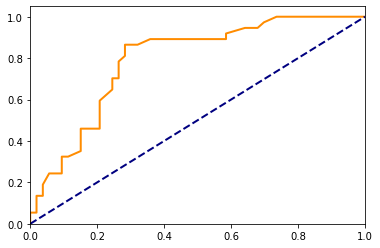

In [7]:
y_pred = rfmodel.predict(X_test)
y_proba = rfmodel.predict_proba(X_test)[:,1]
metrics = evaluate(y_test, y_pred, y_proba)
metrics

{'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0, 'auc': 1.0}

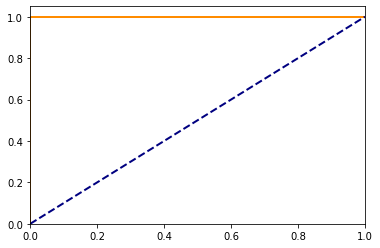

In [8]:
# con train
y_pred = rfmodel.predict(X_train)
y_proba = rfmodel.predict_proba(X_train)[:,1]

evaluate(y_train, y_pred, y_proba)

### El modelo se está sobreajustando, necesitamos tunear las variables

## Tuneo basado en out of bag score

C:\Users\SCASTROM\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\SCASTROM\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\SCASTROM\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\SCASTROM\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\SCASTROM\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too 

Valor óptimo de n_estimators: 61


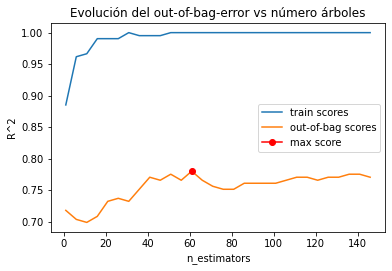

In [9]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestClassifier(
                n_estimators = n_estimators,
                #max_depth    = None,
                #max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

In [13]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100, 120, 150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 4, 5],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 120} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 120} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 120} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 120} ✓
Model

,oob_accuracy,criterion,max_depth,max_features,n_estimators
17,0.784689,gini,3.0,9,150
53,0.784689,entropy,3.0,9,150
16,0.779904,gini,3.0,9,120
51,0.779904,entropy,3.0,9,100


## Validacion cruzada

In [9]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [100, 120, 150],
             # 'max_features': [5, 7, 9],
              'min_samples_leaf': np.arange(10, 41, 5),
              "min_samples_split" : np.arange(5, 30 + 1, 5),
              'max_depth'   : [2, 3, 4],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
268,gini,4,10,30,120,0.764111,0.059154,0.812209,0.016651
269,gini,4,10,30,150,0.764111,0.059789,0.811814,0.018379
643,entropy,4,10,25,120,0.764111,0.065345,0.824171,0.016933
645,entropy,4,10,30,100,0.764034,0.064885,0.813414,0.016444


In [10]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 120} : 0.7641114982578399 accuracy


In [11]:
modelo_final = grid.best_estimator_

In [12]:
print(modelo_final)

RandomForestClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=30,
                       n_estimators=120, random_state=123)


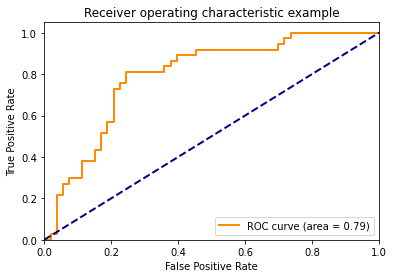

{'recall': 0.2972972972972973,
 'precision': 0.6470588235294118,
 'f1': 0.40740740740740744,
 'accuracy': 0.6444444444444445,
 'auc': 0.791942886282509}

In [13]:
y_pred = modelo_final.predict(X_test)
y_proba = modelo_final.predict_proba(X_test)[:,1]
metrics = evaluate(y_test, y_pred, y_proba)
metrics

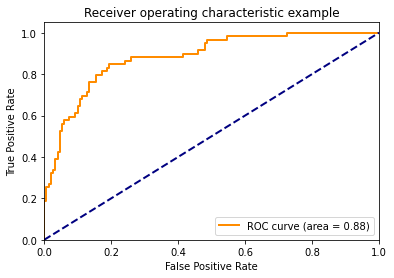

{'recall': 0.4576271186440678,
 'precision': 0.7941176470588235,
 'f1': 0.5806451612903226,
 'accuracy': 0.8133971291866029,
 'auc': 0.8825988700564972}

In [14]:
# con train
y_pred = modelo_final.predict(X_train)
y_proba = modelo_final.predict_proba(X_train)[:,1]
evaluate(y_train, y_pred, y_proba)

In [15]:
from joblib import dump
dump(modelo_final, '../models/random_forest.pkl')

['../models/random_forest.pkl']